In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

import torch.nn as nn
import torchvision.models as models
import torchvision.transforms.functional as TF
from torchinfo import summary

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 24 * 2  # 24 pairs each having x and y coordinates

In [3]:
IMG_DIR = "Images"
JSON = "StanfordExtra_V12/StanfordExtra_v12.json"
KEYPOINT_DEF = (
    "https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
)

# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.
json_dict = {i["img_path"]: i for i in json_data}

In [4]:
json_dict['n02085782-Japanese_spaniel/n02085782_2886.jpg']

{'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg',
 'img_width': 350,
 'img_height': 272,
 'img_bbox': [205, 20, 116, 201],
 'is_multiple_dogs': False,
 'joints': [[108.66666666666667, 252.0, 1],
  [147.66666666666666, 229.0, 1],
  [163.5, 208.5, 1],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [54.0, 244.0, 1],
  [77.33333333333333, 225.33333333333334, 1],
  [79.0, 196.5, 1],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [150.66666666666666, 86.66666666666667, 1],
  [88.66666666666667, 73.0, 1],
  [116.0, 106.33333333333333, 1],
  [109.0, 123.33333333333333, 1],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0]],
 'seg': 'Yi71c01S74jHNU75gHMX75eHM[74cHM\\76`HL4HQ7k0lHXOT7R1O2N010O010jLiNROW1m0lNROT1m0oNPOQ1P1QOoNn0R1ROnNn0oMkNQ2:Nl0oMlNQ2:0j0nMnNP291j0mMoNR280j0kMPOLEg1c0`0i0lMCb1Db0i0jMGa1Ae0h0iMI`1_Og0j0fMK`1\\Oj0i0eMN^1ZOl0i0dM1]1WOm0k0cM2]1TOP1j0bM4\\1ROR1k0`M<W1iNX1l0`M=:ZN4=Q2T3aMXLO8>=Q2k3oMULQ2k3oMTLQ2m3mMULS2j3mMWLS2i3kMY

In [5]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

,Index,Name,Hex colour,Stanford,Animal-pose,(name in animal pose)
0,0,Left front leg: paw,d82400,y,y,L_F_Paw
1,1,Left front leg: middle joint,d82400,y,y,L_F_Knee
2,2,Left front leg: top,d82400,y,y,L_F_Elbow
3,3,Left rear leg: paw,fcfc00,y,y,L_B_Paw
4,4,Left rear leg: middle joint,fcfc00,y,y,L_B_Knee


In [6]:
# Extract the colours and labels.
colours = keypoint_def["Hex colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()

In [7]:
# Utility for reading an image and for getting its annotations.
def get_dog(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

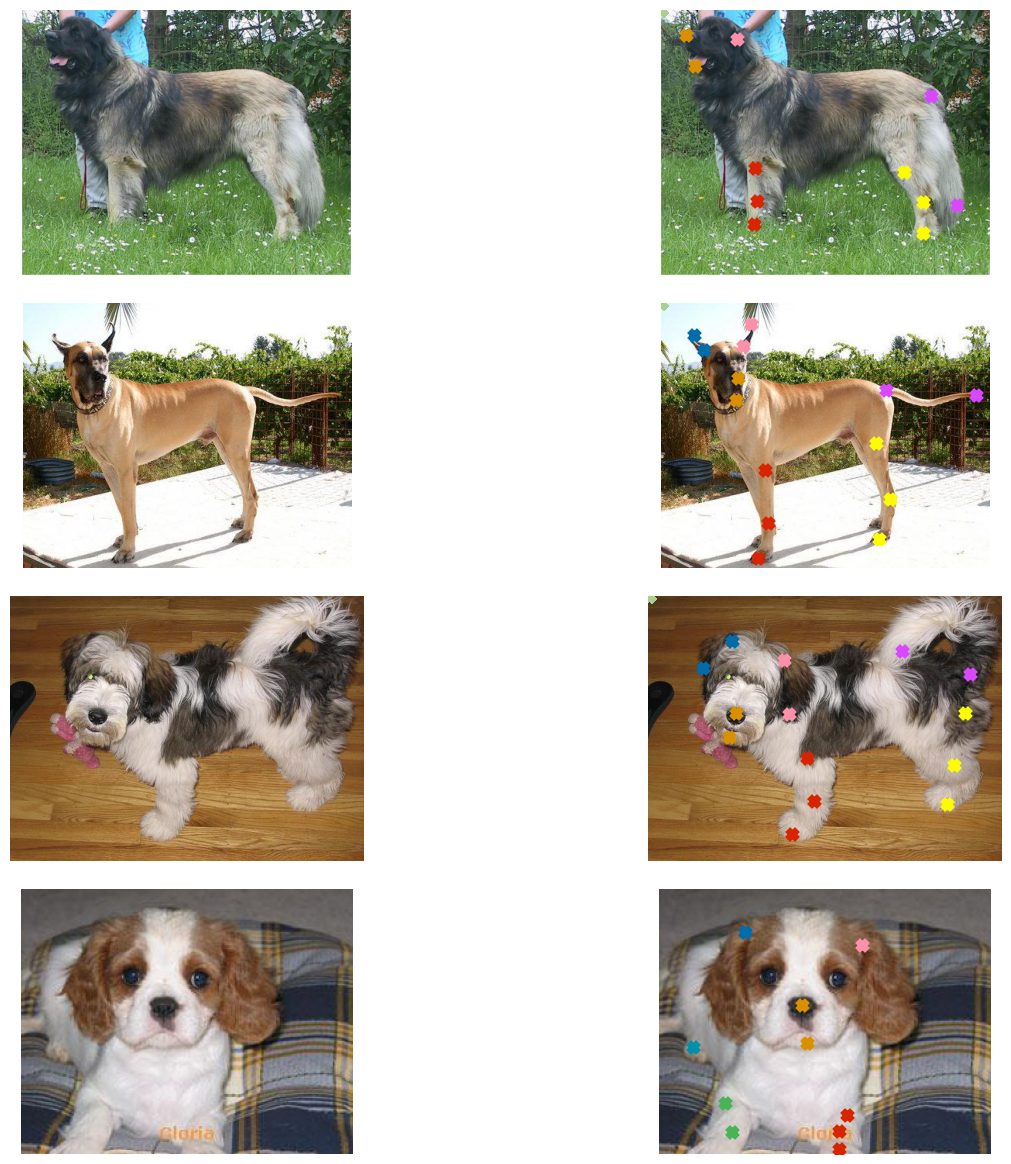

In [8]:
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x],
                    [kp.y],
                    c=colours[idx],
                    marker="x",
                    s=50,
                    linewidths=5,
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_dog(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

In [9]:
class KeyPointsDatasetTorch(Dataset):
    def __init__(self, image_keys, aug, img_size, num_keypoints, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.img_size = img_size
        self.num_keypoints = num_keypoints
        self.train = train

    def __len__(self):
        return len(self.image_keys)

    def __getitem__(self, idx):
        key = self.image_keys[idx]
        data = get_dog(key)

        current_keypoint = np.array(data["joints"])[:, :2]
        kps = []

        # Create keypoint objects
        for j in range(len(current_keypoint)):
            kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

        current_image = data["img_data"]
        kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

        # Apply augmentation
        new_image, new_kps_obj = self.aug(image=current_image, keypoints=kps_obj)

        # Convert image to tensor and normalize
        image_tensor = torch.tensor(new_image, dtype=torch.float32).permute(2, 0, 1) / 255.0

        # Parse keypoints
        kp_temp = []
        for keypoint in new_kps_obj:
            kp_temp.append(np.nan_to_num(keypoint.x))
            kp_temp.append(np.nan_to_num(keypoint.y))

        keypoints_tensor = torch.tensor(kp_temp, dtype=torch.float32).reshape(1, 1, self.num_keypoints * 2)
        keypoints_tensor = keypoints_tensor / self.img_size  # Normalize keypoints

        return image_tensor, keypoints_tensor


In [10]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [11]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

In [12]:
class KeyPointsDatasetTorch(Dataset):
    def __init__(self, image_keys, aug, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.train = train

    def __len__(self):
        return len(self.image_keys)

    def __getitem__(self, idx):
        key = self.image_keys[idx]
        data = get_dog(key)

        current_keypoint = np.array(data["joints"])[:, :2]
        kps = [Keypoint(x=x, y=y) for x, y in current_keypoint]

        current_image = data["img_data"]
        kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

        new_image, new_kps_obj = self.aug(image=current_image, keypoints=kps_obj)

        # Convert image
        image_tensor = torch.tensor(new_image, dtype=torch.float32).permute(2, 0, 1) / 255.0

        # Convert keypoints
        kp_temp = []
        for keypoint in new_kps_obj:
            kp_temp.append(np.nan_to_num(keypoint.x))
            kp_temp.append(np.nan_to_num(keypoint.y))

        keypoints_tensor = torch.tensor(kp_temp, dtype=torch.float32) / IMG_SIZE  # shape: (48,)

        return image_tensor, keypoints_tensor  # no reshape here


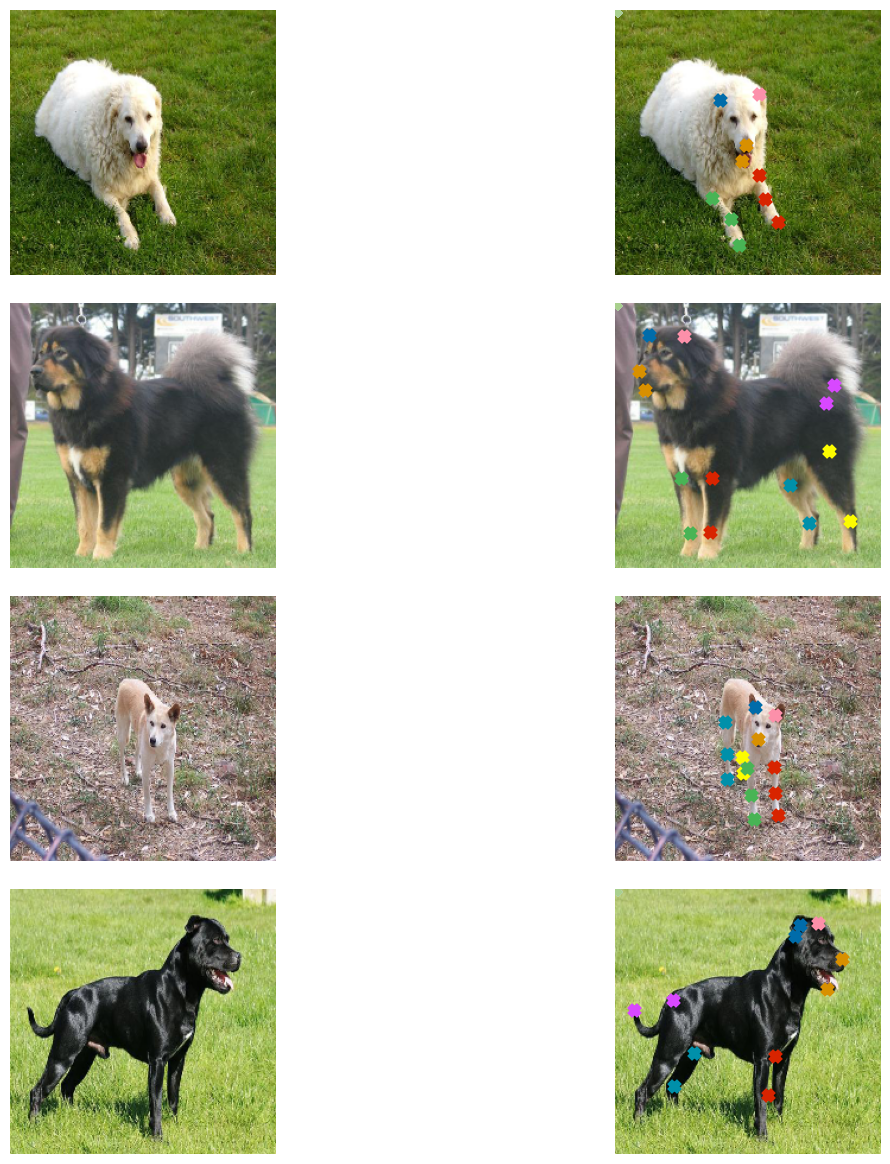

In [13]:
train_dataset = KeyPointsDatasetTorch(train_keys, train_aug)
validation_dataset = KeyPointsDatasetTorch(validation_keys, test_aug, train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Sample batch
sample_images, sample_keypoints = next(iter(train_loader))
assert sample_keypoints.max() <= 1.0
assert sample_keypoints.min() >= 0.0

sample_keypoints_vis = sample_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
sample_images_vis = sample_images[:4].permute(0, 2, 3, 1).numpy() * 255.0
sample_images_vis = sample_images_vis.astype(np.uint8)

visualize_keypoints(sample_images_vis, sample_keypoints_vis.numpy())


In [15]:
# Global Constants
IMG_SIZE = 224
NUM_KEYPOINTS = 24

# SeparableConv2D block (Keras-style)
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=None):
        super().__init__()
        padding = kernel_size // 2
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=kernel_size,
            groups=in_channels, padding=padding, bias=True  # ✅ bias=True to match Keras
        )
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, bias=True  # ✅ also bias=True
        )
        self.activation = None
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        if self.activation:
            x = self.activation(x)
        return x

# Final Keypoint Detector Model
class KeypointDetectorConv(nn.Module):
    def __init__(self, num_keypoints=24):
        super().__init__()
        self.num_outputs = num_keypoints * 2  # (x, y) pairs → 48

        # Backbone
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.backbone = mobilenet.features
        for param in self.backbone.parameters():
            param.requires_grad = False  # Freeze backbone

        # Head
        self.dropout = nn.Dropout(0.3)
        self.sepconv1 = SeparableConv2d(1280, self.num_outputs, kernel_size=5, activation='relu')
        self.sepconv2 = SeparableConv2d(self.num_outputs, self.num_outputs, kernel_size=3, activation='sigmoid')

        # Output pooling to match (B, 48) like Keras
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output: (B, 48, 1, 1)

    def forward(self, x):
        # Normalize like tf.keras.applications.mobilenet_v2.preprocess_input
        x = TF.normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        x = self.backbone(x)            # (B, 1280, 7, 7)
        x = self.dropout(x)
        x = self.sepconv1(x)            # (B, 48, 7, 7)
        x = self.sepconv2(x)            # (B, 48, 7, 7)
        x = self.global_avg_pool(x)     # (B, 48, 1, 1)
        x = x.view(x.size(0), -1)       # Flatten to (B, 48)
        return x  # This is the (x, y) normalized keypoint output

# Instantiate and print summary
IMG_SIZE = 224
model = KeypointDetectorConv(num_keypoints=24)
summary(model, input_size=(1, 3, IMG_SIZE, IMG_SIZE))


C:\Users\muham\anaconda3\envs\scwork\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\muham\anaconda3\envs\scwork\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                             Output Shape              Param #
KeypointDetectorConv                               [1, 48]                   --
├─Sequential: 1-1                                  [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 32, 112, 112]         (864)
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         (64)
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         (896)
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           (5,136)
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential

In [16]:
# Constants
BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Datasets & Dataloaders
train_dataset = KeyPointsDatasetTorch(train_keys, aug=train_aug, train=True)
val_dataset = KeyPointsDatasetTorch(validation_keys, aug=test_aug, train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model, Loss, Optimizer
model = KeypointDetectorConv(num_keypoints=24).to(DEVICE)
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for images, keypoints in train_loader:
        images = images.to(DEVICE)
        keypoints = keypoints.view(images.size(0), -1).to(DEVICE)  # shape: (B, 48)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, keypoints)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, keypoints in val_loader:
            images = images.to(DEVICE)
            keypoints = keypoints.view(images.size(0), -1).to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, keypoints)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch [1/5] - Train Loss: 0.0988 | Val Loss: 0.0864
Epoch [2/5] - Train Loss: 0.0788 | Val Loss: 0.0755
Epoch [3/5] - Train Loss: 0.0763 | Val Loss: 0.0737
Epoch [4/5] - Train Loss: 0.0759 | Val Loss: 0.0709
Epoch [5/5] - Train Loss: 0.0741 | Val Loss: 0.0707


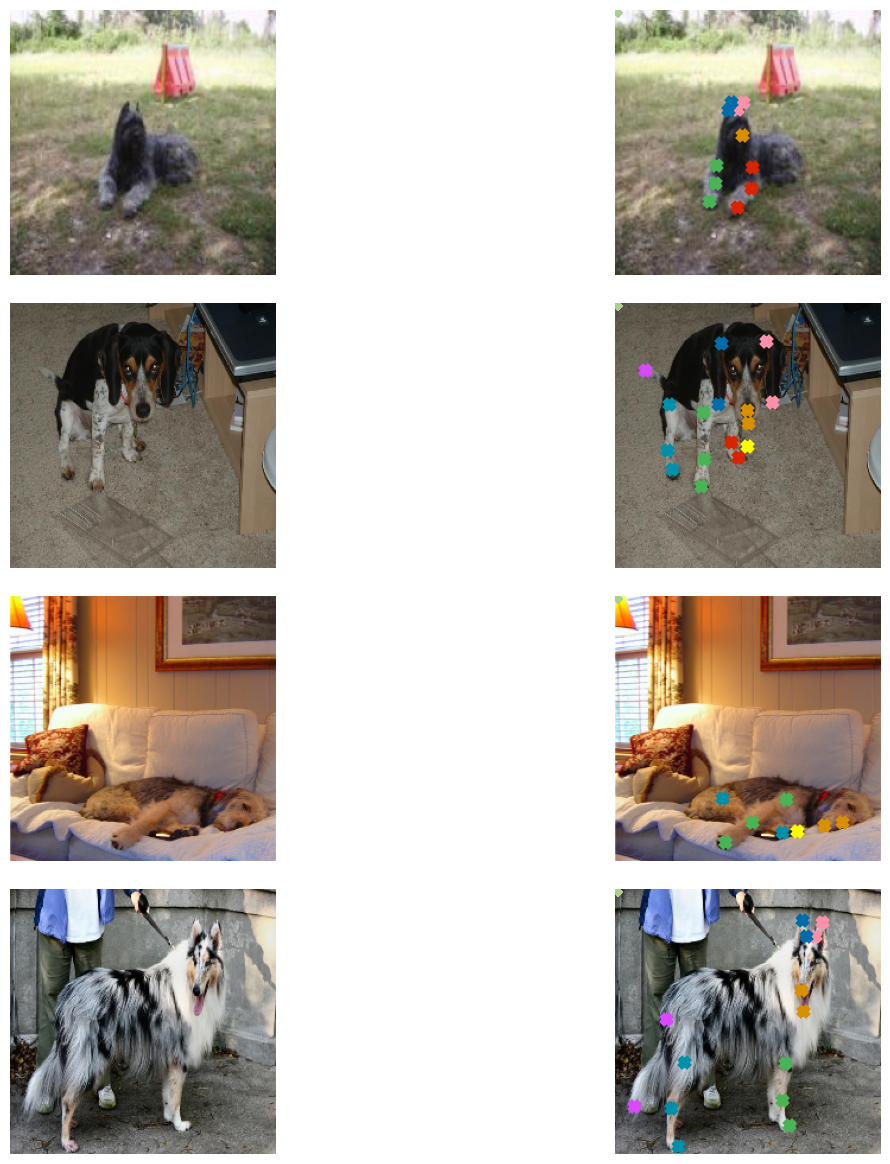

In [ ]:
import matplotlib.pyplot as plt

# Switch model to evaluation mode
model.eval()

# Get one batch from validation set
sample_val_images, sample_val_keypoints = next(iter(val_loader))

# Take only first 4 samples
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].view(-1, 24, 2) * IMG_SIZE

# Move to correct device and predict
with torch.no_grad():
    preds = model(sample_val_images.to(DEVICE))
    preds = preds.view(-1, 24, 2) * IMG_SIZE
    preds = preds.cpu()  # bring to CPU for visualization

# Convert images to numpy for plotting
sample_val_images_np = sample_val_images.permute(0, 2, 3, 1).numpy() * 255.0
sample_val_images_np = sample_val_images_np.astype(np.uint8)

# Visualize ground-truth
visualize_keypoints(sample_val_images_np, sample_val_keypoints.numpy())

# Visualize predictions
visualize_keypoints(sample_val_images_np, preds.numpy())
